**By: Ahmed Abdulghany**

# What is Ensemble Learning?

Imagine you ask a large group of people a complex question. Each person gives an answer. When you combine their answers, you often get a result that’s better than what any individual could offer. This is called the **"wisdom of the crowd."**

In machine learning, you do the same thing. Instead of people, you use multiple models (called predictors), and combine their predictions to make a final decision. This group of models is called an ensemble, and the technique is called **ensemble learning.**

**Random Forest: A Strong Ensemble Method**

One popular example is the Random Forest:
- It’s made up of many Decision Trees.
- Each tree is trained on a random subset of the training data.
- For classification, each tree "votes" for a class.
- The class with the most votes wins—this is the prediction of the random forest.

Why it's great:

    It’s simple yet highly effective.

    Often outperforms individual models.

**When to Use Ensemble Methods?**

Use them towards the end of a machine learning project:
- After you’ve built some good models.
- To combine their strengths and reduce weaknesses.
- To improve accuracy and robustness.

They are common in competitions, like the Netflix Prize, where teams used ensembles to win.

**Types of Ensemble Methods Covered in This Chapter**
1. Voting Classifiers: Combine predictions from different models.
2. Bagging and Pasting: Train models on random subsets.
3. Random Forests: A type of bagging using decision trees.
4. Boosting: Combine weak models into a strong one by focusing on errors.
5. Stacking: Train a new model to combine the predictions of several models.

Ensemble methods are essential tools for real-world ML problems. They’re not just for contests—they can drastically boost performance in practical applications. I recommend Random Forests as a go-to baseline and Boosting (like XGBoost or LightGBM) for competitive performance.

# Voting Classifier

**A Voting Classifier** combines predictions from multiple models (classifiers). There are two types:
- Hard Voting: The final prediction is the class with the most votes.
- Soft Voting: The final prediction is the class with the highest average probability (more confidence = more weight).

Example: If three classifiers predict `[1, 1, 0]`, hard voting chooses `1` because it gets 2 votes.

**Why Voting Works**

Even if each model is only **moderately accurate (e.g., 80%)**, combining them often improves results. Why?

**Analogy: Biased Coin Toss**
- Coin has 51% chance of heads.
- Toss 1,000 times → ~75% chance heads dominates.
- Toss 10,000 times → ~97% chance heads dominates.

This is the **Law of Large Numbers**. Similarly, a large number of weak models (each just a little better than chance) can combine to become very accurate, if their errors are not strongly correlated.

> Diversity is crucial. Using different algorithms (like SVM, logistic regression, random forest) increases the chance that models make different mistakes.

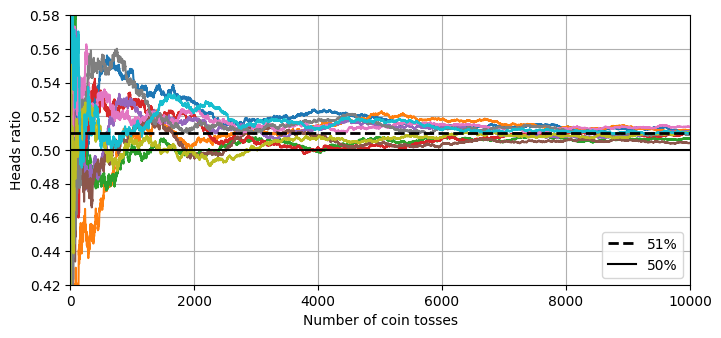

In [1]:
# Figure 7–3

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()

plt.show()

**What the Plot Shows**
- X-axis: Number of coin tosses (from 1 to 10,000)
- Y-axis: Proportion of heads in each series over time
- Colored lines: Each line is a separate series of 10,000 tosses
- Dashed line (51%): The theoretical probability of heads
- Solid line (50%): The halfway mark (i.e., equal heads and tails)

**Observations**
- Early Variation: At the beginning (first few tosses), the ratio of heads varies a lot. It might dip below 50% or go well above.
- Convergence: As the number of tosses increases, all lines start to stabilize around the 51% mark.
- Final Result: By 10,000 tosses, all 10 lines are very close to 51%, demonstrating that the average outcome matches the probability over a large number of trials.

**What This Means**

This is a visual proof of the **Law of Large Numbers**:
- Even if the advantage is tiny (just 1% over chance), repeating the process many times amplifies the effect.
- Small biases can lead to significant cumulative effects.

In machine learning terms:
- A weak model that's only 51% accurate isn’t useful alone.
- But if you combine many independent weak models through majority voting, their combined prediction can be much more accurate—up to 75% or more!
- This only works if the models' errors are uncorrelated.

---

It clearly shows that the power doesn't lie in a single model, but in **quantity + diversity**.
That’s exactly why big companies like Google and Meta use **hundreds of models** in their recommendation engines and search systems. Each model **sees only a piece of the truth**but **together**, they **capture the full picture**



**Let's build a voting classifier:**

In [2]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

1. **Loaded the dataset**
We generated 500 noisy moon-shaped samples using `make_moons()` and split them into training and testing sets using `train_test_split`.

2. **Created a Voting Classifier**

We defined a voting classifier composed of:
    
- `LogisticRegression`
- `RandomForestClassifier`
- `SVC (Support Vector Classifier)`

Each model was assigned a short name (`lr`, `rf`, `svc`) and grouped into the `VotingClassifier`.

3. **Trained the VotingClassifier**

We called `.fit()` on the training set. Behind the scenes, Scikit-Learn **clones and trains** each of the individual estimators.

In [3]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


4. **Evaluated individual models**

We tested how each classifier performed on its own on the test set. Results were:

Logistic Regression: 86.4% accuracy

Random Forest: 89.6% accuracy

SVC: 89.6% accuracy

In [4]:
voting_clf.predict(X_test[:1])

array([1])

5. **Made predictions using hard voting**

The voting classifier predicted a class label based on majority vote:

- For a given sample, if 2 out of 3 classifiers predicted class `1`, the final prediction was `1`.

In [5]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [6]:
voting_clf.score(X_test, y_test)

0.912

6. **Evaluated hard voting performance**

The ensemble classifier (hard voting) achieved **91.2% accuracy**, which outperformed all three individual models

**Improving with Soft Voting:**

In [7]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

7. **Enabled soft voting**

We switched to soft voting by:

- Setting `voting="soft"`
- Enabling `probability=True` in the `SVC`, so it can output class probabilities using cross-validation.

After retraining with these changes, the model reached 92% accuracy — slightly higher than with hard voting.

In [8]:
voting_clf.fit(X_train, y_train)
print("Accuracy:", voting_clf.score(X_test, y_test))

Accuracy: 0.92


**Result:**
- Individual classifiers: ~86–89% accuracy
- Voting classifier (hard): 91.2%
- Voting classifier (soft): 92%

**Tips**
- Use diverse models for better results.
- Prefer soft voting when possible—more accurate when classifiers can estimate probabilities.
- Avoid using similar models trained on the same data—they'll likely make the same mistakes.

**Why Does This Work?**
- Hard voting chooses the majority class across all classifiers.
- Soft voting **averages** predicted probabilities and picks the class with the highest average.
- Soft voting usually performs better because it **takes into account how confident each model is in its prediction**.
- This ensemble method is especially effective when the individual models are diverse and make different kinds of errors.

Voting classifiers offer an easy win in most ML tasks. They're fast to implement and often give substantial accuracy boosts. Start with hard voting, and if all models support `predict_proba`, switch to soft voting for better performance.

# Bagging and Pasting

Bagging and pasting are ensemble techniques that improve the performance of models by training them on **different subsets** of the training data.

**What's the Main Idea?**

Instead of training one model on the full dataset, you:
- Train **multiple models** on random subsets of the data.
- Use the **same algorithm** for each model (e.g., decision tree).
- Combine their predictions (majority vote or average) for final output.

**Bagging vs. Pasting**
| Feature             | Bagging                 | Pasting                       |
| ------------------- | ----------------------- | ----------------------------- |
| Sampling            | **With replacement**    | **Without replacement**       |
| Duplicate instances | Possible in each subset | Not allowed in each subset    |
| Diversity           | Usually more diverse    | Slightly less diverse         |
| Usage               | More common and robust  | Less common but can be faster |

Bagging = Bootstrap Aggregating

**Why It Works**

Each model sees a different view of the data, so:
- They make different errors.
- Combining them reduces variance (fewer overfitting issues).
- The final model is more stable and often more accurate.

Even though each model may have a slightly higher bias (since it sees less data), the **ensemble's overall bias stays low** while variance drops.

**How Predictions Are Made**
- Classification: Use the mode (majority vote)
- Regression: Use the mean (average of outputs)

This is similar to how a **hard voting** classifier works but applied to models trained on different data samples

**Parallel Processing Advantage**
- Since all models are trained independently, **bagging and pasting scale easily** across **multiple CPU cores or servers**.
- This makes them efficient and fast, especially with large datasets

## Bagging and Pasting in Scikit-Learn

Scikit-Learn makes it easy to use bagging and pasting with the BaggingClassifier (or BaggingRegressor for regression tasks).

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,      # 500 trees
    max_samples=100,       # each tree sees 100 samples
    bootstrap=True,        # sampling with replacement (Bagging)
    n_jobs=-1,             # use all CPU cores
    random_state=42
)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

> To use Pasting, simply set `bootstrap=False`.

**Soft Voting with Bagging**
- If the base classifier supports `predict_proba()` (like `DecisionTreeClassifier)`, BaggingClassifier uses soft voting.
- This typically leads to better performance because it weighs predictions by confidence.

--- 

**Performance Comparison: Single Tree vs. Bagging**

**Single Decision Tree:**

    Low bias, high variance

    Tends to overfit

    Decision boundary is irregular and sensitive to noise

**Bagging with 500 Trees:**

    Slightly higher bias

    Much lower variance

    Decision boundary is smoother and more robust

>This leads to better generalization, meaning it performs better on unseen data.

---

**In Practical**

    Bagging is usually better than pasting, because the randomness in sampling (with replacement) increases model diversity.

    More diversity → less correlation between models → lower overall variance.

    However, you can test both with cross-validation to see which performs best on your data.

**Tips**
- Use `n_estimators ≥ 100` for good performance (500 is a solid default).
- Use `n_jobs=-1` to fully utilize your hardware.
- You can visualize decision boundaries to compare overfitting (jagged lines in single trees vs. smooth boundaries in bagging).

Bagging with decision trees is one of the most reliable ensemble techniques. It’s easy to implement, works well out-of-the-box, and is great for reducing overfitting. I recommend it as a first step before trying more complex methods like Boosting.

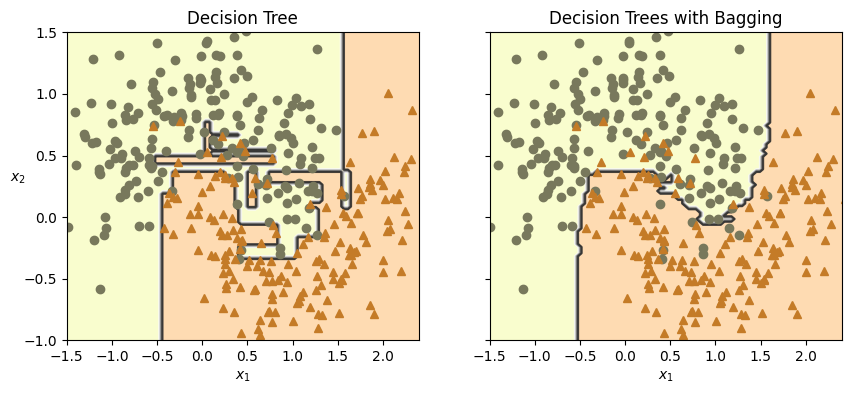

In [13]:
# Figure 7–5

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")

plt.show()

| Aspect            | Single Tree (Left) | Bagging (Right) |
| ----------------- | ------------------ | --------------- |
| Bias              | Low                | Slightly higher |
| Variance          | High               | Low             |
| Overfitting Risk  | High               | Low             |
| Generalization    | Poor               | Much better     |
| Decision Boundary | Jagged             | Smooth          |


## Out-of-Bag evaluation

When using bagging, each model in the ensemble is trained on a bootstrap sample—a random subset of the training set with replacement. This creates a powerful side effect: some training instances are left out in each sample. These are called Out-of-Bag (OOB) instances.

Key Facts About OOB Instances

    About 63% of the training data is used in each bootstrap sample.

    About 37% is left out and becomes OOB data for that specific model.

    Different models have different OOB subsets.

How OOB Evaluation Works
1. Each model makes predictions on the data points it didn't see during training (its OOB instances).
2. For each training instance, combine the predictions from all models where that instance was OOB.
3. Compare those predictions with the true labels to estimate performance—no need for a validation set.

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

bag_clf.fit(X_train, y_train)
print(bag_clf.oob_score_)  # e.g., 0.896 (or 89.6% accuracy)

0.896


> The OOB score is stored in `bag_clf.oob_score_`

**Compare with Actual Test Accuracy**

In [15]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))  # e.g., 0.92 or 92%

0.92


Observation:

The OOB estimate (89.6%) was slightly lower than the actual test accuracy (92%). This is normal—OOB is a conservative estimate, but still a reliable performance indicator.

**Class Probabilities with OOB**

If your base model supports `predict_proba()`, you can also get class probabilities for each training instance from the OOB predictors:

In [16]:
print(bag_clf.oob_decision_function_[:3])
# Example output:
# [[0.3235, 0.6765], [0.3375, 0.6625], [1.0, 0.0]]

[[0.32352941 0.67647059]
 [0.3375     0.6625    ]
 [1.         0.        ]]


This tells you:

    Instance 1: ~67.6% chance of class 1

    Instance 2: ~66.3% chance of class 1

    Instance 3: 100% predicted as class 0

| Feature                   | OOB Evaluation                       |
| ------------------------- | ------------------------------------ |
| Uses separate validation? | No — reuses training data            |
| Saves time & memory       | Yes                                  |
| Reliable metric?          | Often very close to test accuracy    |
| Outputs probabilities     | If `predict_proba()` is available    |

OOB evaluation is one of the most underrated benefits of bagging. It saves you from needing a separate validation set, offers solid performance estimates, and gives class probabilities—all for free. I always recommend enabling `oob_score=True` when using bagging ensembles.

--- 
If you randomly draw one instance from a dataset of size _m_, each instance in the dataset obviously has probability 1/_m_ of getting picked, and therefore it has a probability 1 – 1/_m_ of _not_ getting picked. If you draw _m_ instances with replacement, all draws are independent and therefore each instance has a probability (1 – 1/_m_)<sup>_m_</sup> of _not_ getting picked. Now let's use the fact that exp(_x_) is equal to the limit of (1 + _x_/_m_)<sup>_m_</sup> as _m_ approaches infinity. So if _m_ is large, the ratio of out-of-bag instances will be about exp(–1) ≈ 0.37. So roughly 63% (1 – 0.37) will be sampled.

In [17]:
# extra code – shows how to compute the 63% proba
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


# Random Patches and Random Subspaces

These are advanced bagging techniques where you not only sample data instances but also input features. This increases model diversity, reduces variance, and can speed up training, especially with high-dimensional data like images or text.

**Random Patches**

- Sample both: training instances and features
- Controlled by:
    `max_samples` (for instance sampling)
    `max_features` (for feature sampling)
    `bootstrap` (whether instance sampling is with replacement)
    `bootstrap_features` (whether feature sampling is with replacement)

Use case: When your dataset has a lot of features, and you want to boost speed and diversity.

**Random Subspaces**
- Keep all training instances
- Sample only features
- Settings:
    `bootstrap=False`
    `max_samples=1.0` (use all samples)
    `bootstrap_features=True` and/or `max_features < 1.0`

Use case: Useful when each feature provides a different “perspective” on the data (e.g., image channels, sensor readings).

**Why Use These Methods?**

| Benefit                | Explanation                                    |
| ---------------------  | ---------------------------------------------- |
| More Diversity         | Predictors trained on different views of data  |
| Lower Variance         | Ensemble smooths out unique model errors       |
| Faster Training        | Each model sees fewer features → less overhead |
| Slightly Higher Bias   | Due to reduced information per predictor       |


| Method               | Samples Instances | Samples Features | Settings                              |
| -------------------- | ----------------- | ---------------- | ------------------------------------- |
| **Bagging**          |  Yes              |  No              | `bootstrap=True`, `max_features=1.0`  |
| **Random Subspaces** |  No               |  Yes             | `bootstrap=False`, `max_features<1.0` |
| **Random Patches**   |  Yes              |  Yes             | `bootstrap=True`, `max_features<1.0`  |


# Random Forests
Random Forests are one of the most effective and widely used ensemble learning methods. They’re essentially bagging ensembles of decision trees—but smarter and more efficient.

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=500,      # 500 decision trees
    max_leaf_nodes=16,     # restrict tree complexity
    n_jobs=-1,             # use all CPU cores
    random_state=42
)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

> This trains a forest of 500 shallow trees. Great for balancing speed, accuracy, and generalization.

**Random Forest vs. BaggingClassifier**

| Aspect                     | RandomForestClassifier      | BaggingClassifier + DecisionTree |
| -------------------------- | --------------------------- | -------------------------------- |
| Tree base model            | Auto-optimized random trees | You specify the tree model       |
| Feature selection at split | Random subset at each node  | Not random unless you set it     |
| Simpler interface          | Yes                         |  More manual setup               |

RandomForestClassifier is more optimized and easier to use than combining `BaggingClassifier` with `DecisionTreeClassifier`.

**How Random Forest Adds Randomness**

Unlike basic decision trees:

    Each tree in a Random Forest is trained on a bootstrap sample of the data.

    At each split, the tree picks the best feature from a random subset, not the best from all features.

**This:**

    Increases tree diversity

    Reduces overfitting

    Lowers correlation between trees

    Improves generalization

By default, `max_features="sqrt"` for classification tasks (i.e., √n features at each split).

**Equivalent Manual Setup with BaggingClassifier**

You can replicate the behavior of `RandomForestClassifier` like this:

In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, 
    n_jobs=-1, 
    random_state=42
)

> But using `RandomForestClassifier` is simpler, faster, and offers more built-in optimizations.

| Benefit                  | Explanation                                 |
| ------------------------ | ------------------------------------------- |
|  High Accuracy           | Works well with little tuning               |
|  Low Maintenance         | Fewer parameters to worry about             |
|  Fast & Parallelizable    | Trees are trained independently             |
|  Robust to Overfitting   | Random splits + bagging reduces variance    |
|  Feature Importance       | Built-in attribute: `.feature_importances_` |


Random Forests are one of the best all-around models for classification tasks. They’re easy to use, rarely overfit, and provide strong performance across a wide range of datasets. Start here before moving to more complex models like Gradient Boosting.

# Extra-Trees
Extra-Trees, short for Extremely Randomized Trees, are a variation of Random Forests with even more randomness. This can lead to faster training and sometimes better generalization.

**Key Differences: Random Forest vs. Extra-Trees**
| Feature                     | Random Forest                          | Extra-Trees                            |
| --------------------------- | -------------------------------------- | -------------------------------------- |
| Feature selection at splits | Random subset of features              | Same                                   |
| Threshold selection         | Best threshold per feature             | **Random threshold** per feature       |
| Bootstrap sampling          | Default: True                          | Default: **False**                     |
| Training speed              | Slower (due to threshold optimization) | **Faster** (no threshold optimization) |
| Variance                    | Low                                    | Even **lower** due to added randomness |
| Bias                        | Moderate                               | **Slightly higher**                    |

**When to Use Extra-Trees?**

    You need faster training (e.g., very large datasets)

    Your model is overfitting (try more randomness)

    You want to compare ensemble strategies (always validate with CV)

**Tip**
- It’s impossible to know upfront whether a `RandomForestClassifier` or an `ExtraTreesClassifier` will perform better.

    Use cross-validation to compare them on your dataset.

---

Extra-Trees are an excellent tool when you want a fast, low-variance ensemble and you're okay with a slight bias increase. They often shine when training time is critical or when dealing with noisy, high-dimensional data.

If you're already using Random Forests, try Extra-Trees too—it’s often just a **one-line change** and could boost performance or speed

# Feature Importance

One of the best features of Random Forests is that they **automatically** compute feature importances. This helps you understand which features are most influential in making predictions, making Random Forests not just powerful, but also interpretable.

How Feature Importance is Calculated

    For each decision tree:

        Every time a feature is used to split a node, it reduces the impurity (like Gini or entropy).

        The reduction in impurity is tracked and weighted by the number of samples passing through that node.

    These values are averaged across all trees.

    Then they are normalized so that all importances sum to 1.0

In [21]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Interpretation:

    Petal length and width dominate classification (~86% of total importance).

    Sepal measurements contribute little to model performance.

**MNIST Example: Visualizing Pixel Importance**

If you train a `RandomForestClassifier` on the MNIST digit dataset:
- You can visualize `feature_importances_` as a 28x28 image.
- Bright pixels = high importance
- Dark pixels = low importance

This tells you which parts of the image the model finds useful (often the edges and digit strokes).

**Why Use Feature Importances?**
| Benefit                     | Explanation                                     |
| --------------------------- | ----------------------------------------------- |
|  Insight                  | Understand what drives predictions              |
|  Feature Selection        | Drop unimportant features to simplify the model |
|  Visualization            | Great for high-dimensional data like images     |
|  Dimensionality Reduction | Faster training, lower risk of overfitting      |


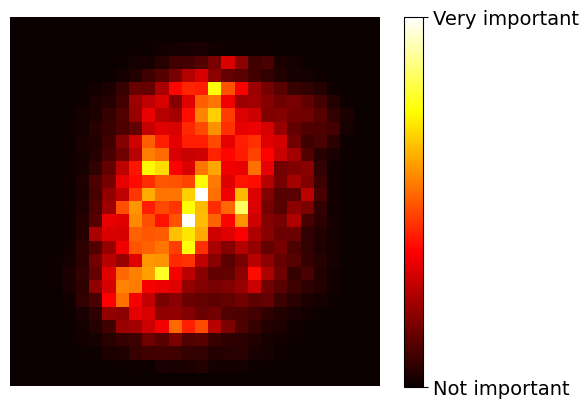

In [22]:
# Figure 7–6

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")

plt.show()

Feature importance from Random Forests is a must-use tool. It adds transparency to black-box models and makes it easy to trim your feature set while keeping performance high. I strongly recommend it as a first step in feature selection and model explanation.

# Boosting
Boosting is a powerful ensemble technique that turns weak learners into a strong learner by training them sequentially, not in parallel like bagging.

**Core Idea**

    Train a first model on the data.

    Measure where it makes mistakes.

    Train a second model that focuses on those mistakes.

    Repeat, creating a sequence of models, each correcting the errors of the previous one.

This process helps the ensemble gradually improve and converge to a very accurate model.

**Most Popular Boosting Methods**

    AdaBoost (Adaptive Boosting)

    Gradient Boosting

Both build models additively, but differ in how they adjust and correct the previous learners.

## AdaBoost: Focused, Sequential Learning
AdaBoost (Adaptive Boosting) is a powerful boosting method that creates a strong learner by combining many weak learners, with each one focusing more on the mistakes of the previous ones.

**How AdaBoost Works**
1. Start with equal weights for all training instances.
2. Train the first weak learner (e.g., decision stump).
3. Identify misclassified instances and increase their weights.
4. Train the next learner, focusing more on these hard cases.
5. Repeat the process for `n_estimators`

Each learner gets a weight α, based on its accuracy:
- High accuracy → higher α
- Random guessing → α ≈ 0
- Worse than guessing → negative α

Final prediction = weighted majority vote of all learners.

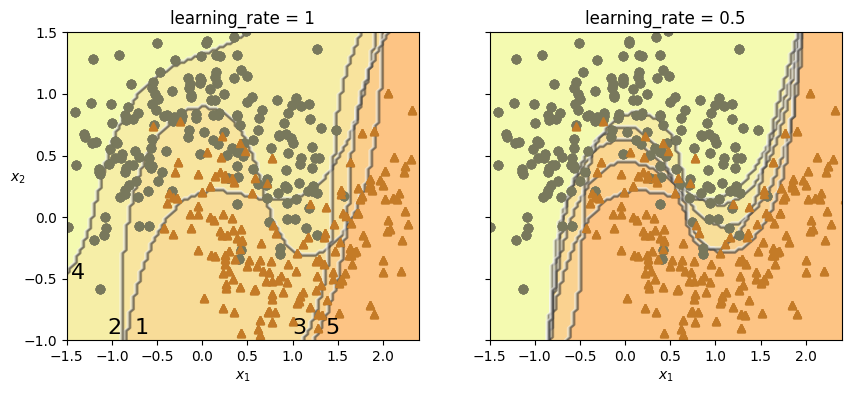

In [23]:
# Figure 7–8

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

plt.show()

| Aspect              | Left (learning\_rate = 1.0)      | Right (learning\_rate = 0.5)         |
| ------------------- | -------------------------------- | ------------------------------------ |
| Adjustment strength | Strong                           | Moderate                             |
| Learning speed      | Faster                           | Slower                               |
| Risk of overfitting | Higher                           | Lower                                |
| Boundary changes    | Sharp and focused                | Smooth and gradual                   |
| Visual impression   | Abrupt transitions, strong bends | Smoother transitions, gentler shifts |

This figure illustrates the trade-off between speed and stability in boosting. A high learning rate helps AdaBoost converge fast but can lead to overfitting, especially on noisy data. A lower rate may need more iterations but results in more robust and generalizable models.

> Always tune `learning_rate` with cross-validation for best results.

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

/home/ahmedabdulghany/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

- Uses 30 decision stumps (trees with `max_depth=1`)
- Learning rate controls how much each learner contributes

**In Practical**
- Cannot parallelize: Each model depends on the previous → slower training
- Works best with simple models: Stumps or shallow trees
- Control overfitting:

    Reduce `n_estimators`
  
    Lower `learning_rate`
  
    Increase regularization on base estimators

**Variants**
- SAMME: Multiclass version of AdaBoost
- SAMME.R: Uses class probabilities (requires `predict_proba()`) → better performance

AdaBoost is excellent when used with care—especially in low-bias, high-variance situations. It often beats bagging on clean data, but it's sensitive to noise and slower to train. Start with it when you need a sharp focus on hard cases and don't mind sequential training.

## Gradient Boosting: A Powerful, Precise Approach to Boosting

Gradient Boosting builds an ensemble of models in a sequential way—like AdaBoost—but with a key difference: it fits each new model to the residual errors of the previous model, rather than adjusting instance weights.

In [27]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

# Generate a simple noisy quadratic dataset
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

In [28]:
# First tree
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [29]:
# Fit residuals
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [30]:
# Fit residuals again
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [31]:
# Predict
X_new = np.array([[-0.4], [0.], [0.5]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)

[0.49484029 0.04021166 0.75026781]


**Using GradientBoostingRegressor for Simplicity**

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

- `learning_rate=1.0`: Full weight per tree (like no shrinkage)
- `n_estimators=3`: Builds 3 trees (same as manual version)


| Term                             | Explanation                                                                           |
| -------------------------------- | ------------------------------------------------------------------------------------- |
| **Residuals**                    | The errors from the previous model’s predictions                                      |
| **Shrinkage**                    | Lower `learning_rate` → smaller tree impact → needs more trees, better generalization |
| **Early Stopping**               | Stops training when no improvement is seen after `n_iter_no_change` rounds            |
| **Stochastic Gradient Boosting** | Use a subset of training data per tree (`subsample < 1.0`) → faster, less overfitting |


**Early Stopping Example**

In [34]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=0.05,
    n_estimators=500,
    n_iter_no_change=10,
    random_state=42
)
gbrt_best.fit(X, y)
print(gbrt_best.n_estimators_)  # e.g., 92

92


- Trains until 10 rounds without significant improvement
- Uses a 10% validation set (`validation_fraction=0.1`)
- Faster, avoids overfitting

**Stochastic Gradient Boosting**

In [37]:
gbrt_stochastic = GradientBoostingRegressor(
    subsample=0.25,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

- Each tree trained on 25% of the data
- Adds randomness → more diversity, lower variance, faster training

| Feature        | AdaBoost                        | Gradient Boosting                   |
| -------------- | ------------------------------- | ----------------------------------- |
| Error Handling | Adjusts sample weights          | Fits residuals                      |
| Training Style | Sequential                      | Sequential                          |
| Parallelizable | ❌ No                            | ❌ No                                |
| Regularization | `n_estimators`, `learning_rate` | Same + `subsample`, early stopping  |
| Typical Use    | Simpler models (e.g., stumps)   | More complex patterns, deeper trees |


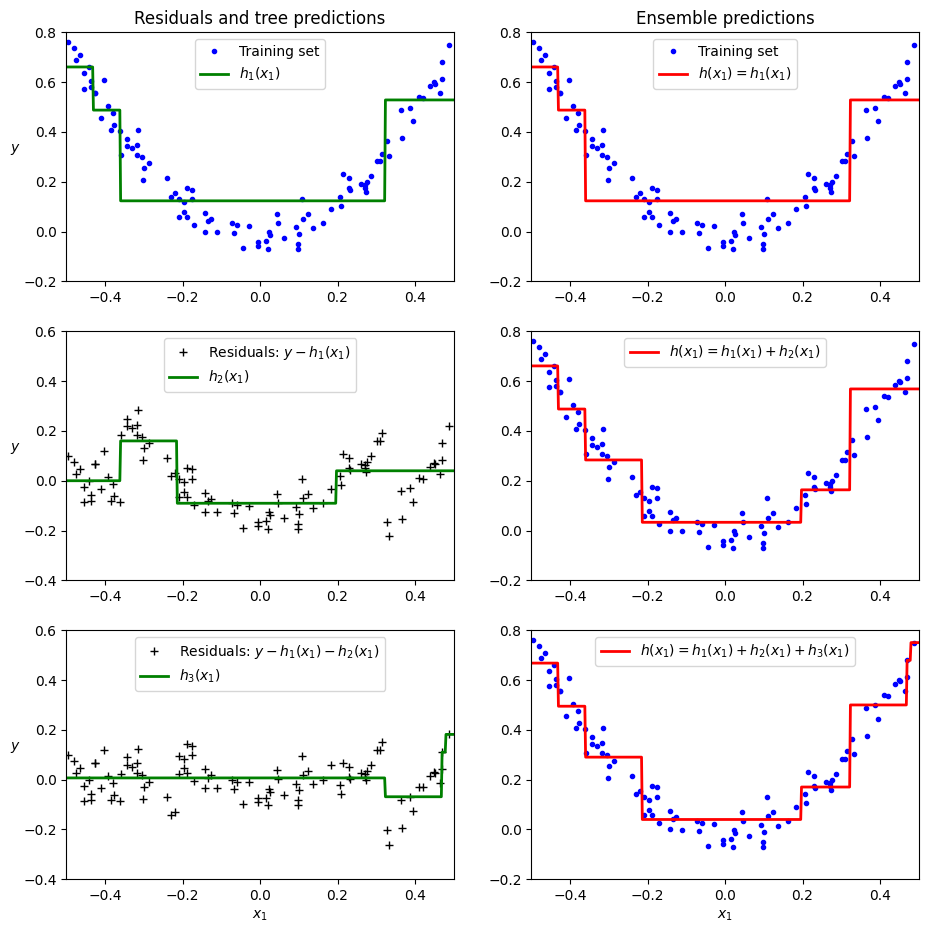

In [32]:
# Figure 7–9

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

**Left Column: Individual Tree Predictions on Residuals**
| Subplot | What It Shows                                             |
| ------- | --------------------------------------------------------- |
| (1,1)   | First tree `h₁(x₁)` fits the original target `y`          |
| (2,1)   | Second tree `h₂(x₁)` fits the residuals: `y - h₁(x₁)`     |
| (3,1)   | Third tree `h₃(x₁)` fits residuals: `y - h₁(x₁) - h₂(x₁)` |
>Residuals are shown as black "+" signs, and each green line shows how the tree is fitting them.

**Right Column: Cumulative Ensemble Predictions**
| Subplot | What It Shows                                     |
| ------- | ------------------------------------------------- |
| (1,2)   | Initial ensemble prediction = `h(x₁) = h₁(x₁)`    |
| (2,2)   | Adds second tree: `h(x₁) = h₁(x₁) + h₂(x₁)`       |
| (3,2)   | Full ensemble: `h(x₁) = h₁(x₁) + h₂(x₁) + h₃(x₁)` |
>Red lines show how the overall prediction improves as trees are added.

This figure perfectly illustrates the elegance of gradient boosting. Instead of trying to learn everything at once, it builds up understanding incrementally, correcting mistakes step-by-step. It’s a core strength of boosting algorithms, making them incredibly accurate and adaptable.

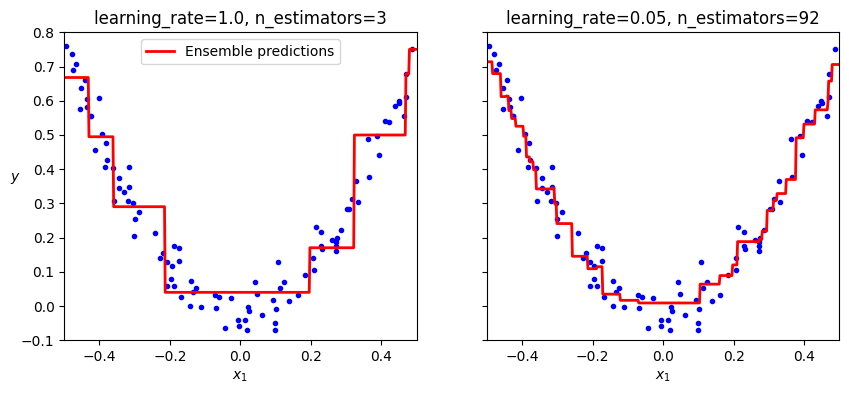

In [38]:
# Figure 7–10

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

plt.show()

**Effect of Learning Rate and Number of Trees in Gradient Boosting**

This figure compares two Gradient Boosting models trained on the same data but with different hyperparameter settings—specifically `learning_rate` and `n_estimators`

**Left Subplot: `gbrt`**

    Learning rate: 1.0

    Number of trees: 3

    Behavior:

        Very aggressive learning due to high learning rate.

        Not enough trees to capture the full complexity of the data.

        Underfits the training data → prediction curve is too simple.

Conclusion: High learning rate + few trees → underfitting.

**Right Subplot: `gbrt_best`**

    Learning rate: 0.05

    Number of trees: 500 max, but early stopping stopped at 92

    Behavior:

        Lower learning rate results in more careful, incremental improvements.

        Early stopping prevents overfitting by halting when no further improvement is detected.

        Produces a much better fit, closely modeling the quadratic trend in the data.

Conclusion: Low learning rate + early stopping = well-regularized, better generalizing model.

| Setting                                         | Result                | Risk             |
| ----------------------------------------------- | --------------------- | ---------------- |
| High learning rate + few trees                  | Underfitting          | Poor predictions |
| Low learning rate + many trees + early stopping | Balanced and accurate | Slower to train  |

This figure clearly shows how critical learning rate and number of estimators are in Gradient Boosting. I highly recommend starting with a low learning rate (e.g., 0.05) and using early stopping to control complexity. It usually gives superior performance without manual tuning.

## Histogram-Based Gradient Boosting (HGB): Speed Meets Simplicity
Histogram-Based Gradient Boosting (HGB) is an optimized version of Gradient Boosting in Scikit-Learn, built for large datasets. It drastically speeds up training by simplifying and quantizing feature values.

**How It Works**

    HGB bins feature values into discrete buckets (integers).

    This reduces the number of possible split points → fewer calculations.

    Enables use of integer-based data structures, which are much faster and memory-efficient.

**Computational Advantage**

| Method       | Complexity                      |
| ------------ | ------------------------------- |
| Classic GBRT | $O(n \cdot m \cdot \log m)$     |
| HGB          | $O(b \cdot m)$ (b = bins ≤ 255) |

>This leads to training speeds hundreds of times faster on big datasets.

| Feature              | HGB Support                                                       |
| -------------------- | ----------------------------------------------------------------- |
| Early stopping       | Auto-enabled for >10,000 samples                                  |
| Categorical features | Yes (as integer codes)                                          |
| Missing values       | Yes                                                             |
| Subsampling          | Not supported                                                   |
| Preprocessing needed | Minimal (just ordinal encoding)                                   |
| Scikit-learn classes | `HistGradientBoostingRegressor`, `HistGradientBoostingClassifier` |


**HGB with California Housing Dataset**

In [40]:
# extra code – at least not in this chapter, it's presented in chapter 2

import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

NameError: name 'Path' is not defined

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder 

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

NameError: name 'housing' is not defined

In [ ]:
# extra code – evaluate the RMSE stats for the hgb_reg model

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

**Hyperparameters Summary**

| Parameter              | Purpose                                |
| ---------------------- | -------------------------------------- |
| `max_iter`             | Number of boosting rounds (trees)      |
| `max_bins` (≤255)      | Controls binning granularity           |
| `early_stopping`       | Auto-on if n > 10,000 (customizable)   |
| `categorical_features` | Use integer column index or bool array |


HGB is a massive upgrade for anyone working with large or high-dimensional data. It’s blazing fast, handles missing data and categories, and often requires minimal preprocessing. I highly recommend it for tabular regression/classification tasks—especially as a starting point or quick baseline.

**Alternatives Worth Exploring**

Other fast and powerful gradient boosting frameworks:

    XGBoost

    LightGBM

    CatBoost

    TensorFlow Decision Forests

These libraries offer:

    GPU support

    Advanced regularization

    More tuning flexibility

    Often higher accuracy

# Stacking: The Smartest Way to Combine Models

Stacking, or stacked generalization, is a powerful ensemble method that goes beyond simple techniques like voting. Instead of using a rule to combine model outputs, stacking trains a new model (blender or meta-learner) to combine them.

**How Stacking Works**
1. Train base models on the training data (e.g., logistic regression, SVM, random forest).
2. Use cross-validation to generate out-of-sample predictions from each base model.
3. Use these predictions to build a new dataset:
 
    Rows = training instances
   
    Columns = predictions from base models

4. Train a blender (meta-learner) on this new dataset.
5. Retrain the base models on the full original dataset.

The meta-learner then learns how to best combine the outputs of the base models.

In [41]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5 
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [42]:
stacking_clf.score(X_test, y_test)

0.928

> Accuracy: ~92.8% — slightly better than the soft voting classifier (92%).

**Stacking vs. Voting**

| Feature          | Voting (Hard/Soft)  | Stacking                           |
| ---------------- | ------------------- | ---------------------------------- |
| Combines using   | Majority or average | **Learned** model                  |
| Final prediction | Fixed rule          | Trained meta-learner               |
| Customizable     | Limited             | Highly customizable                |
| Performance      | Good                | Often **better**                   |
| Complexity       | Low                 | **Higher** (requires CV, training) |

**Deep Stacking (Optional)**

    You can stack multiple layers of meta-learners.

    Can marginally improve performance.

    But increases complexity and training time.

**Tips for Using Stacking**
- Diverse base models work best (e.g., tree + linear + kernel).
- Choose a simple final estimator (e.g., logistic regression, ridge regression).
- Use `cv` to avoid overfitting during stacking.
- Tune hyperparameters of both base and meta models for best results.

Stacking is one of the smartest ensemble techniques because it lets the model learn how to weigh its components. It’s ideal when your base models are strong but diverse and when you're looking to squeeze out extra performance beyond simple ensembling. While more complex, it's worth using in high-stakes tasks or competitions.